In [1]:
import os 
import glob
import zipfile
import dolfyn as dlfn
import xarray as xr
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.dates as mdates
from dolfyn.adp import api
from matplotlib import pyplot as plt
import matplotlib.dates as dt

In [27]:
# READ AD2CP FILES AND MERGE
wdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw')
zdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw','zipped-files')
indir    = os.path.join(wdir + '/*.sigVM')

# deal with the file formats. Change file extensions to zip from sigVM and unzip
fname =glob.glob(indir)

In [27]:
if fname:
    for i in fname:
        print(i)
        bn = os.path.splitext(os.path.basename(i))[0]
        old=i
        new=os.path.join(zdir,bn+'.zip')
        os.rename(old, new)
        
indir    = os.path.join(zdir + '/*.zip')        
fname =glob.glob(indir)
fname 

In [27]:
if fname:
    for i in fname:
        with zipfile.ZipFile(i,"r") as zip_ref:
            zip_ref.extractall(zdir)

# GET ALL AD2CP FILES 
ad2cpdir= os.path.join(zdir + '/*.AD2CP')
fname =glob.glob(ad2cpdir)

# GET ALL NMEA FILES
ndir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','batch-process-GNSS')
nmdir    = os.path.join(ndir + '/*_Data')
nmname =glob.glob(nmdir)

Checking 101512_20210803T080024UTC
Checking 101512_20210803T115712UTC
Checking 101512_20210803T122249UTC
Checking 101512_20210803T123800UTC
Checking 101512_20210803T134245UTC
Checking 101512_20210803T134759UTC
Checking 101512_20210803T135245UTC
Checking 101512_20210803T140532UTC
Checking 101512_20210803T141910UTC
Checking 101512_20210803T150612UTC
Checking 101512_20210804T070330UTC
Checking 101512_20210804T070703UTC
Checking 101512_20210804T130703UTC
Checking 101512_20210804T190703UTC
skipping 101512_20210805T010703UTC
Checking 101512_20210808T054706UTC
Checking 101512_20210808T114706UTC
Checking 101512_20210815T103205UTC
Checking 101512_20210815T110326UTC
Checking 101512_20210815T110849UTC
Checking 101512_20210826T122815UTC
Checking 101512_20210826T135107UTC
Checking 101512_20210826T195107UTC
Checking 101512_20210827T015107UTC
Checking 101512_20210827T075107UTC


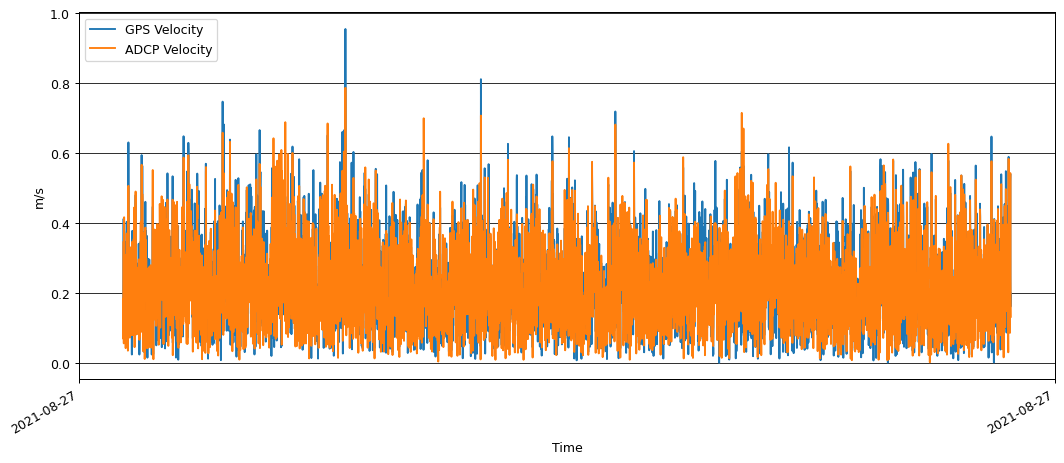

Reading file c:/Users\sa01ld\OneDrive - SAMS\Projects\Autonaut-EE\Non-Acoustic data\process-raw\zipped-files\101512_20210827T075107UTC.AD2CP ...
Data is already in the beam coordinate system
Data is already in the beam coordinate system


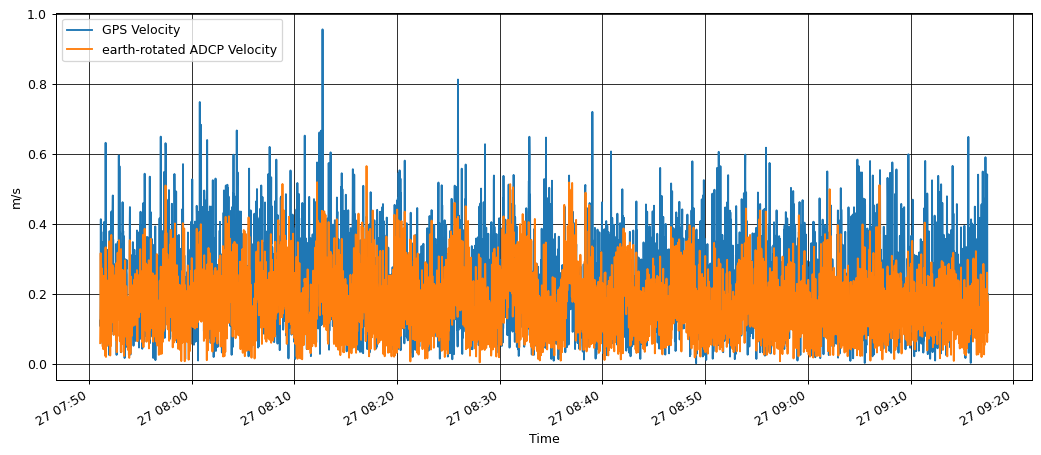

Checking 101512_20211006T181158UTC
Checking 101512_20211007T001158UTC
Checking 101512_20211007T061158UTC
Checking 101512_20211007T121158UTC
Checking 101512_20211007T181158UTC
Checking 101512_20211007T190648UTC
Checking 101512_20211008T010648UTC
Checking 101512_20211008T070648UTC
skipping 101512_20211008T130648UTC
skipping 101512_20211008T190648UTC
Checking 101512_20211013T234259UTC
Checking 101512_20211014T000326UTC


In [27]:
# set variables for append
GPSEast=[]
GPSNorth=[]
VEast=[]
VNorth=[]

first = True
xx=0

for i,j in zip(fname,nmname):
        if i in ['c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20211008T190648UTC.AD2CP','c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20211008T130648UTC.AD2CP','c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210805T010703UTC.AD2CP']:
            bn = os.path.splitext(os.path.basename(i))[0] # unique file ID
            print('skipping ' + bn)
            continue
        
        # read csv files and extract lat and long data
        bn = os.path.splitext(os.path.basename(i))[0] # unique file ID
        print('Checking ' + bn)
        
        if bn in ['101512_20210827T075107UTC']:
            csvpath=os.path.join(j,bn+'.csv')
            df=pd.read_csv(csvpath) # nav data 

            
            asv=np.square(df.GPSEast.values)+np.square(df.GPSNorth.values)
            asv=np.sqrt(asv) 

            adcp=np.square(df.VEast.values)+np.square(df.VNorth.values)
            adcp=np.sqrt(adcp) 
            time=df.Date_Time
            timex = np.array(time, dtype='datetime64[s]')
            
            # make new dataframe
            ndf = df[['Date_Time', 'GPSHeading', 'SHeading']].copy()
            ndf.insert(1, "adcpVel", adcp,allow_duplicates=True)
            ndf.insert(1, "asvVel", asv,allow_duplicates=True)
            
            
            if asv.any():
                %matplotlib inline
                fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
                plt.plot(timex,asv, label="GPS Velocity")
                plt.plot(timex,adcp, label="ADCP Velocity")
                plt.xlabel("Time")
                plt.ylabel("m/s")
                plt.legend(loc='upper left')
                plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000)) 
                plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
                fig.autofmt_xdate()
                figfile=os.path.join('figures/' +'gps_speed_vs_adcp_speed_processed'+ bn + '.png')
                fig.savefig(figfile, dpi=100, facecolor='white')
                plt.show()
                
            # GPS derived velocities
            GPSEast.append(df.GPSEast.values)
            GPSNorth.append(df.GPSNorth.values)
            VEast.append(df.VEast.values)
            VNorth.append(df.VNorth.values)

            
            da = dlfn.read(i) # adcp data  
            
            # apply correlation filter
            
            # look at the correlation values
            %matplotlib inline
            da.corr.sel(beam=1, range=slice(0,10)).plot()
            
            # clean the data with threshold of 50%
            da = api.clean.correlation_filter(da, thresh=50)

            # rotate to earth coordinates
            da = dlfn.rotate2(da, 'earth', inplace=True)
            
            # surface current values
            dv_east=np.mean(da.vel.sel(dir='E', range=slice(0,5)).values,axis=0)
            dv_north=np.mean(da.vel.sel(dir='N', range=slice(0,5)).values,axis=0)
            dv_time=da.time.values+3600
            dv_time = np.array(dv_time, dtype='datetime64[s]')
            
            ev=np.square(dv_east)+np.square(dv_north)
            ev=np.sqrt(ev) 
            
            
            if dv_east.any():
                %matplotlib inline
                fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
                plt.plot(timex,asv, label="GPS Velocity")
                plt.plot(dv_time,ev, label="earth-rotated ADCP Velocity")
                plt.xlabel("Time")
                plt.ylabel("m/s")
                plt.legend(loc='upper left')
                plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
                fig.autofmt_xdate()
#                 ax.set_xlim([datetime.date(2021, 8, 27), datetime.date(2021, 8, 28)])
                figfile=os.path.join('figures/' +'gps_speed_vs_earth-rotated-adcp_speed_processed'+ bn + '.png')
                fig.savefig(figfile, dpi=100, facecolor='white')
                plt.show()
                
            # merge the ADCP dat sets
            if first:
                first = False
                ds=da
            else:
                ds=xr.merge([ds,da])
        xx=xx+1
    
if xx>=1:
    VEast=np.concatenate(VEast)
    GPSEast=np.concatenate(GPSEast)
    GPSNorth=np.concatenate(GPSNorth)

In [28]:
ndf

,Date_Time,asvVel,adcpVel,GPSHeading,SHeading
0,2021-08-27T07:51:07.43,0.123069,0.183295,250.69,212.68
1,2021-08-27T07:51:08.43,0.106527,0.070214,249.64,211.50
2,2021-08-27T07:51:09.43,0.192800,0.122188,248.51,211.72
3,2021-08-27T07:51:10.43,0.412656,0.348013,248.35,209.98
4,2021-08-27T07:51:11.43,0.151013,0.056939,246.52,208.50
...,...,...,...,...,...
5179,2021-08-27T09:17:26.43,0.521015,0.383308,291.31,254.36
5180,2021-08-27T09:17:27.43,0.540634,0.543332,291.51,254.18
5181,2021-08-27T09:17:28.43,0.161555,0.248574,291.42,255.16
5182,2021-08-27T09:17:29.43,0.195369,0.178709,291.95,255.48


In [8]:
da

<xarray.Dataset>
Dimensions:              (beam: 4, dir: 4, dirIMU: 3, earth: 3, inst: 3, q: 4, range: 17, time: 5186, time_bt: 5186, x*: 4)
Coordinates:
  * dir                  (dir) <U2 'E' 'N' 'U1' 'U2'
  * time_bt              (time_bt) float64 1.63e+09 1.63e+09 ... 1.63e+09
  * dirIMU               (dirIMU) <U1 'E' 'N' 'U'
  * time                 (time) float64 1.63e+09 1.63e+09 ... 1.63e+09 1.63e+09
  * beam                 (beam) int32 1 2 3 4
  * range                (range) float64 5.0 9.0 13.0 17.0 ... 61.0 65.0 69.0
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * x*                   (x*) int32 1 2 3 4
Data variables: (12/50)
    c_sound              (time) float32 1.5e+03 1.5e+03 ... 1.5e+03 1.5e+03
    temp                 (time) float32 15.47 15.47 15.47 ... 15.48 15.48 15.48
    pressure             (time) float32 0.975 0.972 0.981 ... 0.968 0.972 0.966
    heading              (time) float32 214.0 212.7 211.5 ... 255.5 255.4 255.8
    pitch                (time) float32 1.69 1.53 -1.58 1.37 ... 2.06 -0.2 -0.52
    roll                 (time) float32 179.3 -177.0 179.8 ... -179.1 179.3
    ...                   ...
    dist_bt              (dir, time_bt) float32 -1.0 -1.0 -1.0 ... -1.0 -1.0
    orientmat_bt         (earth, inst, time_bt) float32 -0.5547 ... -0.9998
    angrt_bt             (dirIMU, time_bt) float32 0.04944 0.09071 ... -0.01898
    quaternion_bt        (q, time_bt) float32 -0.009552 -0.00119 ... 0.009979
    fom_bt               (dir, time_bt) uint16 65535 65535 65535 ... 65535 65535
    beam2inst_orientmat  (beam, x*) float32 1.183 0.0 -1.183 ... 0.0 0.5518
Attributes: (12/34)
    filehead_config:  {'CLOCKSTR': {'TIME': '"2021-08-26 13:51:05"'}, 'ID': '...
    inst_model:       Signature500
    inst_make:        Nortek
    inst_type:        ADCP
    rotate_vars:      ['vel', 'accel', 'accel_bt', 'angrt', 'angrt_bt', 'mag'...
    burst_config:     {'press_valid': True, 'temp_valid': True, 'compass_vali...
    ...               ...
    power_level_bt:   0
    coord_sys:        earth
    orientation:      AHRS
    orient_status:    AHRS-3D
    has_imu:          1
    fs:               1

In [3]:
# get moving average
a_series = pd.Series(ev)
rolling_window_obj = a_series.rolling(50)
ra_ev = rolling_window_obj.mean()
ra_ev.size

a_series = pd.Series(asv)
rolling_window_obj = a_series.rolling(50)
ra_asv = rolling_window_obj.mean()
ra_asv.size


5184

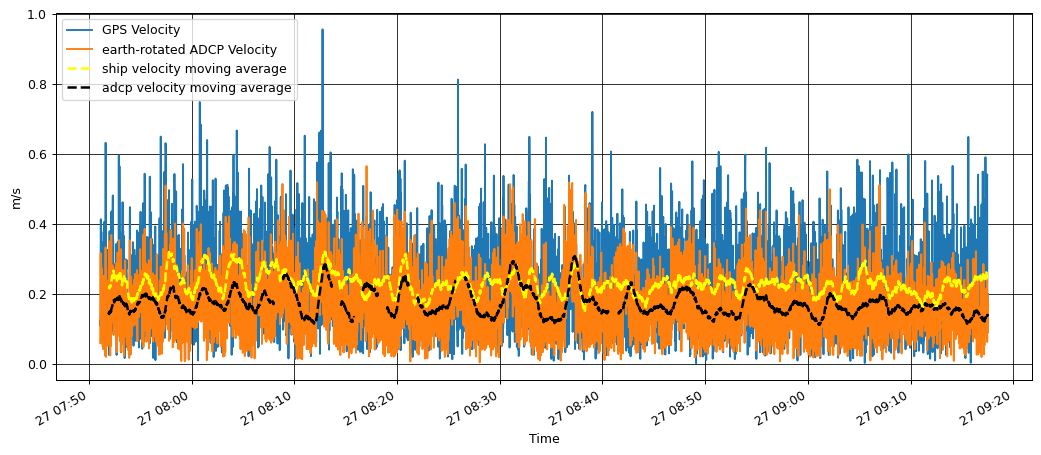

In [4]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(timex,asv, label="GPS Velocity")
plt.plot(dv_time,ev, label="earth-rotated ADCP Velocity")
plt.plot(timex,ra_asv, color='yellow', linestyle='dashed', linewidth=2,label="ship velocity moving average")
plt.plot(dv_time,ra_ev, color='black', linestyle='dashed', linewidth=2,label="adcp velocity moving average")
plt.xlabel("Time")
plt.ylabel("m/s")
plt.legend(loc='upper left')
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
fig.autofmt_xdate()
#                 ax.set_xlim([datetime.date(2021, 8, 27), datetime.date(2021, 8, 28)])
figfile=os.path.join('figures/' +'gps_speed_vs_earth-rotated-adcp_speed_processed'+ bn + '.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

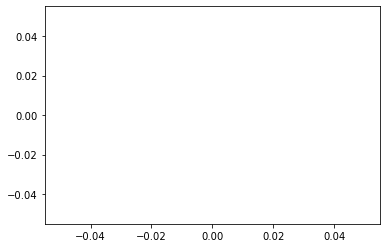

In [5]:
# try integrate the values for a depth average
v_east=da.vel.sel(dir='E').values
z=da.range.values
dz=np.diff(z)
v_east=v_east.T
dac=np.trapz(v_east,x=z)
plt.plot(dac)

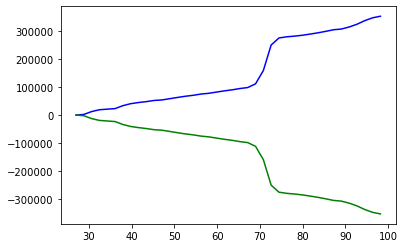

In [6]:
# some fake data
data = ds.corr
# evaluate the histogram
values, base = np.histogram(data, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
#plot the survival function
plt.plot(base[:-1], len(data)-cumulative, c='green')

plt.show()

In [ ]:
%matplotlib inline
ds.vel.sel(dir=1, range=slice(0,70)).plot()

Earth: When the data object is in ‘earth’ coordinates, the first dimension of vectors are: [East, North, Up, …]. This coordinate system is also sometimes denoted as “ENU”. If the declination is set the earth coordinate system is “True-East, True-North, Up” otherwise, East and North are magnetic. See the Declination Handling section for further details on setting declination.

In [ ]:
bn

In [ ]:
Evel=dd.vel.sel(dir=1,range=5)
Nvel=dd.vel.sel(dir=2,range=5)


In [ ]:
%matplotlib inline
ds.corr.sel(beam=1, range=slice(0,70)).plot()

In [ ]:
ds = api.clean.correlation_filter(ds, thresh=50)

%matplotlib inline
ds.corr.sel(beam=1, range=slice(0,70)).plot()

In [ ]:
ds_avg['U_mag'] = ds_avg.velds.U_mag
ds_avg['U_dir'] = ds_avg.velds.U_dir
ds_avg['U_dir'].data = dlfn.tools.misc.convert_degrees(ds_avg['U_dir'].values, tidal_mode=True)

%matplotlib inline
ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot the horizontal velocity magnitude
t = dlfn.time.dt642date(ds_avg.time)
plt.pcolormesh(t, ds_avg.range, ds_avg['U_mag'], cmap='Blues', shading='nearest')
# Plot the water surface
ax.plot(t, ds_avg.depth)

# Set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12])
plt.colorbar(label='Horizontal Vel [m/s]')